In [3]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

In [4]:
class TensorNetwork:
    def __init__(self, graph, tensors):
        self.graph = graph
        self.tensors = tensors
        self.index_dims = {}
        self.index_to_tensors = {}

        for name, (tensor, indices) in tensors.items():
            for idx, dim in zip(indices, tensor.shape):
                if idx in self.index_dims:
                    assert self.index_dims[idx] == dim, f"Index {idx} has conflicting dimensions: {self.index_dims[idx]} and {dim}"
                else:
                    self.index_dims[idx] = dim
                self.index_to_tensors.setdefault(idx, []).append((name, tensor, indices))


In [5]:
def evaluate_config(network, config):
    result = 1.0
    for name, (tensor, inds) in network.tensors.items():
        key = tuple(config[idx] for idx in inds)
        result *= tensor[key]
    return result

def update_edge(network, config, idx, beta=1.0):
    tensors = network.index_to_tensors[idx]
    dim = network.index_dims[idx]
    probs = np.ones(dim)
    for name, arr, inds in tensors:
        slc = [config[i] if i != idx else slice(None) for i in inds]
        probs *= arr[tuple(slc)] ** beta
    if probs.sum() > 0:
        probs /= probs.sum()
    else:
        probs = np.ones(dim) / dim
    
    config[idx] = np.random.choice(dim, p=probs)

def estimate_contraction(network, betas, iters=10000, burns=1000, verbose=False,
                         return_traj=False, return_weights=False):
    config = {idx: np.random.randint(dim) for idx, dim in network.index_dims.items()}
    logZ = 0.0
    logZ_traj = []
    all_weights = []

    for i in range(1, len(betas)):
        beta_prev, beta_curr = betas[i - 1], betas[i]
        delta_beta = beta_curr - beta_prev
        weights = []

        for t in range(iters):
            idx = np.random.choice(list(network.index_dims.keys()))
            update_edge(network, config, idx, beta=beta_curr)
            if t >= burns:
                w = evaluate_config(network, config)
                if w > 0:
                    weights.append(w ** (-delta_beta))

        weights = np.array(weights)
        ratio_est = np.mean(weights)
        if ratio_est <= 0:
            raise ValueError(f"Nonpositive mean weight at β={beta_curr}")

        logZ -= np.log(ratio_est)
        if return_traj:
            logZ_traj.append(logZ)
        if return_weights:
            all_weights.append(weights)

        if verbose:
            print(f"[β = {beta_curr:.2f}] E[ψ^(-Δβ)] = {ratio_est:.6f} → partial logZ = {logZ:.6f}")

    Z_est = np.exp(logZ) * np.prod([dim for dim in network.index_dims.values()])

    results = [Z_est]
    if return_traj:
        results.append(logZ_traj)
    if return_weights:
        results.append(all_weights)

    return tuple(results) if len(results) > 1 else results[0]

In [6]:
# testing networks
def generate_cycle_network(N=4, D=3):
    G = nx.cycle_graph(N)
    tensors = {}
    for i in G.nodes():
        neighbors = sorted(G.neighbors(i))
        idx_1, idx_2 = f'e{i}-{neighbors[0]}', f'e{i}-{neighbors[1]}'
        tensor = np.random.rand(D, D)
        tensors[i] = (tensor, [idx_1, idx_2])
    return TensorNetwork(G, tensors)

def generate_random_graph_tn(n=6, p=0.4, D=2):
    G = nx.erdos_renyi_graph(n, p)
    tensors = {}
    edge_map = {}
    for u, v in G.edges():
        idx = f'e{u}-{v}'
        edge_map[(u, v)] = idx
        edge_map[(v, u)] = idx
    for node in G.nodes():
        neighbors = list(G.neighbors(node))
        idxs = [edge_map[(node, nbr)] for nbr in neighbors]
        shape = [D] * len(idxs)
        tensor = np.random.rand(*shape)
        tensors[node] = (tensor, idxs)
    
    return TensorNetwork(G, tensors)

def run_multiple_chains(network, betas, n_chains=5, iters=20000, burns=1000):
    estimates = []
    trajectories = []

    for seed in range(n_chains):
        np.random.seed(seed)
        Z_est, traj = estimate_contraction(
            network, betas, iters=iters, burns=burns, verbose=False, return_traj=True
        )
        estimates.append(Z_est)
        trajectories.append(traj)
    
    # plotting trajectories of log Z per beta to check smoothness
    for i, traj in enumerate(trajectories):
        plt.plot(betas, traj, label=f'Chain {i+1}')
    plt.xlabel('Beta')
    plt.ylabel('Accumulated Log Z')
    plt.title('Log Z Trajectories on Multiple Chains')
    plt.legend()
    plt.grid(True)
    plt.show()

    return np.mean(estimates), np.std(estimates)


In [7]:
# test on Tr(ABCD)

# G = nx.Graph()
# G.add_edges_from([
#     ('A', 'B'),
#     ('B', 'C'),
#     ('C', 'D'),
#     ('D', 'A'),
# ])

# edge_labels = {
#     ('A', 'B'): 'j',
#     ('B', 'C'): 'k',
#     ('C', 'D'): 'l',
#     ('D', 'A'): 'i',
# }

# #define tensors with matching shared indices
# dim = 3
# A = np.random.rand(dim, dim)
# B = np.random.rand(dim, dim)
# C = np.random.rand(dim, dim)
# D = np.random.rand(dim, dim)

# tensors = {
#     'A': (A, ['i', 'j']),
#     'B': (B, ['j', 'k']),
#     'C': (C, ['k', 'l']),
#     'D': (D, ['l', 'i'])
# }

# tn = TensorNetwork(G, tensors)
# betas = np.linspace(0, 1, 50)
# n_chains = 10
# iters = 200000
# burns = 5000

# mean_Z, std_Z = run_multiple_chains(tn, betas, n_chains=n_chains, iters=iters, burns=burns)
# tensors = tn.tensors

# A, B, C, D = [tensors[i][0] for i in sorted(tensors)]
# true_trace = np.trace(A @ B @ C @ D)

# print(f"Estimated Z: {mean_Z:.4f} ± {std_Z:.4f}")
# print(f"True trace: {true_trace:.4f}")

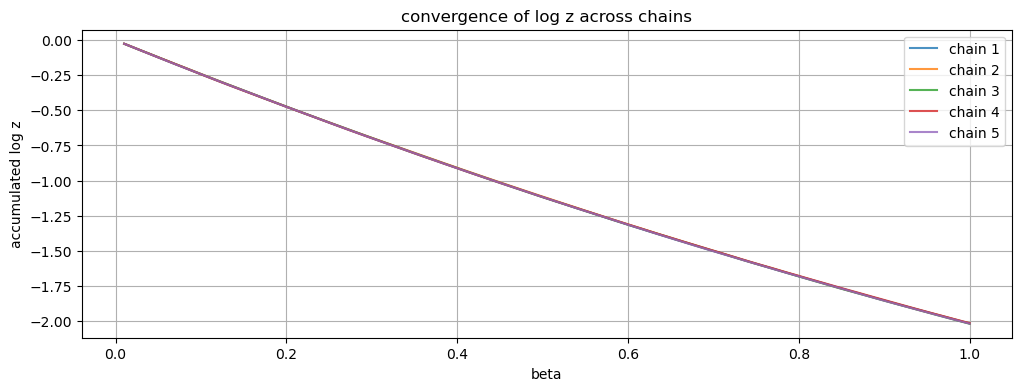

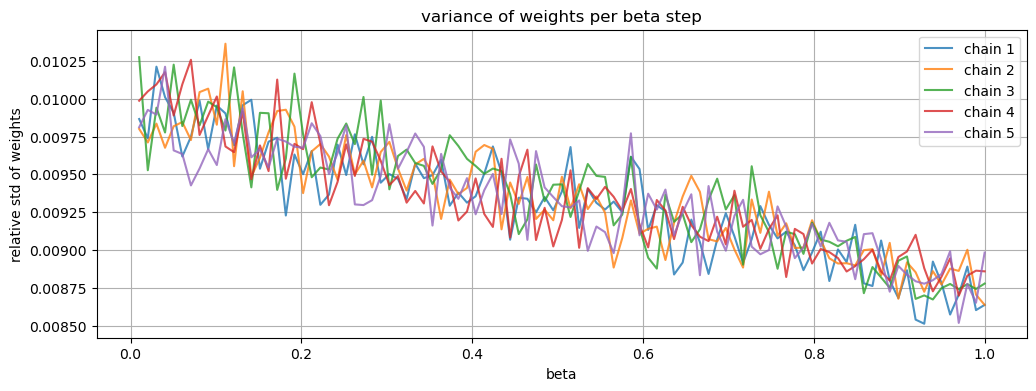

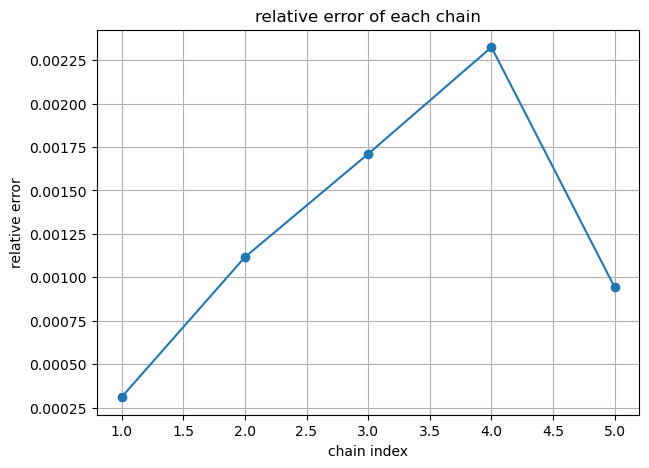

samples: 1000, relative error: 1.152894e-02
samples: 2000, relative error: 4.650522e-03
samples: 5000, relative error: 4.784473e-03
samples: 10000, relative error: 6.179468e-03
samples: 20000, relative error: 2.716082e-03
samples: 40000, relative error: 1.044454e-03


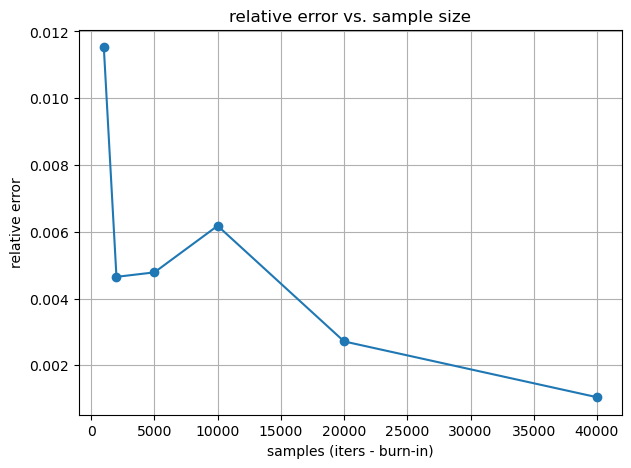


estimated tr(ABCD): 10.758467 ± 0.015450
true tr(ABCD): 10.756104


In [14]:
def run_multiple_chains(network, betas, n_chains, iters, burns, Z_true=None, sample_sizes_to_check=None):
    estimates = []
    logZ_trajectories = []
    weight_variances = []
    sample_sizes = []

    # loop over multiple chains
    for seed in range(n_chains):
        np.random.seed(seed)

        # run ais for this chain
        Z_est, logZ_traj, all_weights = estimate_contraction(
            network, betas, iters=iters, burns=burns, verbose=False,
            return_traj=True, return_weights=True
        )

        estimates.append(Z_est)
        logZ_trajectories.append(logZ_traj)
        sample_sizes.append(iters - burns)

        # calculate relative variance of weights per beta step
        rel_vars = [np.std(w) / np.mean(w) if np.mean(w) > 0 else 0 for w in all_weights]
        weight_variances.append(rel_vars)

    # plot accumulated logZ trajectories
    plt.figure(figsize=(12, 4))
    for i, traj in enumerate(logZ_trajectories):
        plt.plot(betas[1:], traj, label=f'chain {i+1}', alpha=0.8)
    plt.xlabel('beta')
    plt.ylabel('accumulated log z')
    plt.title('convergence of log z across chains')
    plt.grid(True)
    plt.legend()
    plt.show()

    # plot variance of ais weights
    plt.figure(figsize=(12, 4))
    for i, rel_var in enumerate(weight_variances):
        plt.plot(betas[1:], rel_var, label=f'chain {i+1}', alpha=0.8)
    plt.xlabel('beta')
    plt.ylabel('relative std of weights')
    plt.title('variance of weights per beta step')
    plt.grid(True)
    plt.legend()
    plt.show()

    # plot relative error of each chain (at fixed sample size)
    if Z_true is not None:
        errors = [abs(est - Z_true) / abs(Z_true) for est in estimates]
        plt.figure(figsize=(7, 5))
        plt.plot(range(1, n_chains + 1), errors, 'o-')
        plt.xlabel('chain index')
        plt.ylabel('relative error')
        plt.title('relative error of each chain')
        plt.grid(True)
        plt.show()

        # also plot error vs sample size by varying iters
        if sample_sizes_to_check is not None:
            errors_vs_samples = []
            for samples in sample_sizes_to_check:
                # run a single chain for each sample size
                Z_est_tmp = estimate_contraction(
                    network, betas, iters=samples, burns=burns, verbose=False,
                    return_traj=False, return_weights=False
                )
                rel_error_tmp = abs(Z_est_tmp - Z_true) / abs(Z_true)
                errors_vs_samples.append(rel_error_tmp)
                print(f"samples: {samples}, relative error: {rel_error_tmp:.6e}")

            plt.figure(figsize=(7, 5))
            plt.plot(sample_sizes_to_check, errors_vs_samples, 'o-')
            plt.xlabel('samples (iters - burn-in)')
            plt.ylabel('relative error')
            plt.title('relative error vs. sample size')
            plt.grid(True)
            plt.show()

    return np.mean(estimates), np.std(estimates)


def test_trace_ABCD(dim=3, betas=np.linspace(0, 1, 100), n_chains=5, iters=5000, burns=500):
    # create the ring graph
    G = nx.Graph()
    G.add_edges_from([
        ('A', 'B'),
        ('B', 'C'),
        ('C', 'D'),
        ('D', 'A'),
    ])

    # generate random positive tensors
    A = np.random.rand(dim, dim) + 0.1
    B = np.random.rand(dim, dim) + 0.1
    C = np.random.rand(dim, dim) + 0.1
    D = np.random.rand(dim, dim) + 0.1

    tensors = {
        'A': (A, ['i', 'j']),
        'B': (B, ['j', 'k']),
        'C': (C, ['k', 'l']),
        'D': (D, ['l', 'i'])
    }

    # compute exact trace
    true_trace = np.trace(A @ B @ C @ D)

    # create the tensor network
    tn = TensorNetwork(G, tensors)

    # define sample sizes to check convergence of error
    sample_sizes_to_check = [1000, 2000, 5000, 10000, 20000, 40000]

    # run ais with multiple chains and also test convergence
    mean_Z, std_Z = run_multiple_chains(tn, betas, n_chains, iters, burns, Z_true=true_trace,
                                        sample_sizes_to_check=sample_sizes_to_check)

    print(f"\nestimated tr(ABCD): {mean_Z:.6f} ± {std_Z:.6f}")
    print(f"true tr(ABCD): {true_trace:.6f}")


# run the test
test_trace_ABCD()

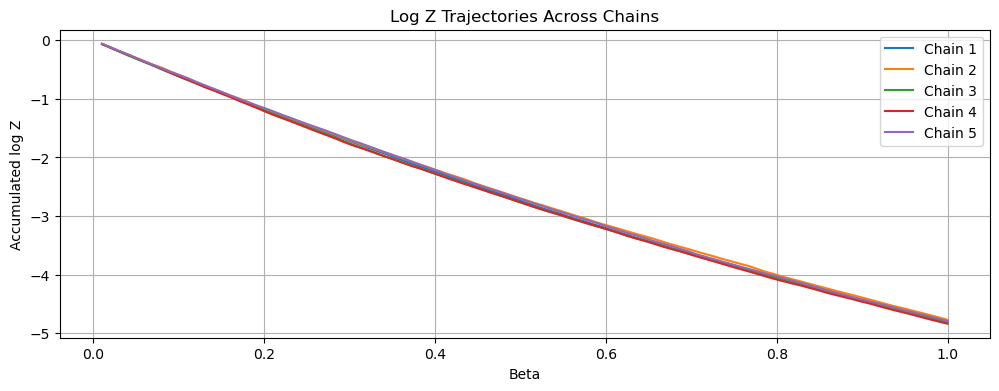

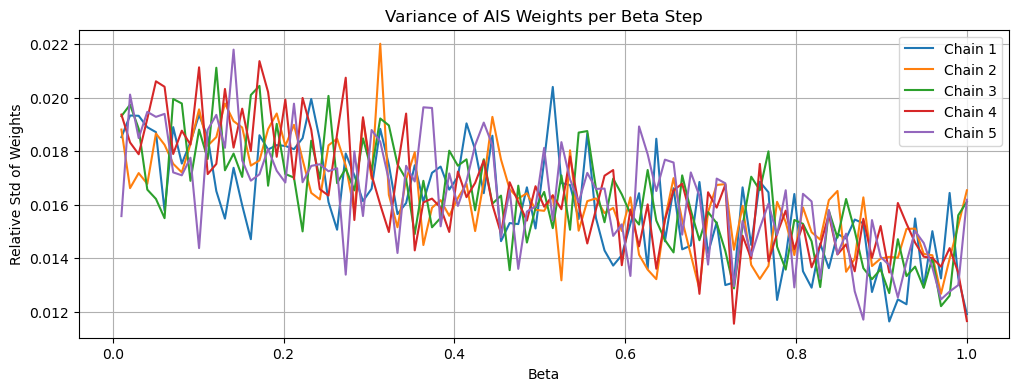

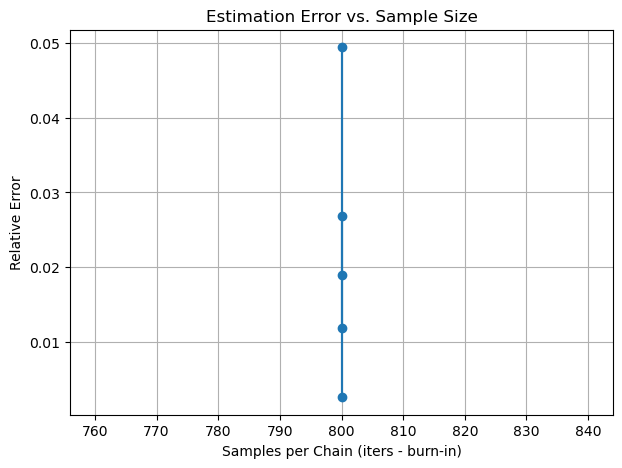


Estimated Z: 2142.780685 ± 49.874907
True Z: 2114.626733


In [9]:
def test_3x3_lattice(dim=2, betas=np.linspace(0, 1, 100), n_chains=5, iters=1000, burns=200):
    import itertools

    # Create 3x3 periodic grid graph
    G = nx.grid_2d_graph(3, 3, periodic=True)
    G = nx.convert_node_labels_to_integers(G)  # 0..8

    # Assign each edge a unique index
    edge_to_idx = {}
    for i, (u, v) in enumerate(G.edges()):
        edge_to_idx[(u, v)] = f'e{u}-{v}'
        edge_to_idx[(v, u)] = f'e{u}-{v}'  # undirected

    # Create tensors with positive entries
    tensors = {}
    for node in G.nodes():
        neighbors = sorted(G.neighbors(node))
        idxs = [edge_to_idx[(node, nbr)] for nbr in neighbors]
        shape = [dim] * len(idxs)
        tensor = np.random.rand(*shape) + 0.1
        tensors[node] = (tensor, idxs)

    # Build TN
    tn = TensorNetwork(G, tensors)

    # Direct contraction (only feasible for very small D)
    exact = 0.0
    all_indices = {idx: range(dim) for idx in tn.index_dims}
    for config in itertools.product(*all_indices.values()):
        cfg = dict(zip(all_indices.keys(), config))
        exact += evaluate_config(tn, cfg)

    # AIS multiple chains
    mean_Z, std_Z = run_multiple_chains(tn, betas, n_chains, iters, burns, Z_true=exact)

    print(f"\nEstimated Z: {mean_Z:.6f} ± {std_Z:.6f}")
    print(f"True Z: {exact:.6f}")

test_3x3_lattice()